Theory: https://pmc.ncbi.nlm.nih.gov/articles/PMC4839495/

- LightGBM (a gradient boosting) seems most popular
- Other multivariate imputations using LightGBM, kNN and Autoencoders or GAN
- For datasets with mixed categorical and continuous variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [2]:
train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
dic = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv")

def frequency_encode_categorical(df_original):
    df = df_original.copy()
    categorical_columns = [
        col for col in df.columns if
        df[col].dtype=="object" and col not in ['ID', "efs", "efs_time"]
    ]
    for column in categorical_columns:
        encoding = df[column].value_counts() / len(df)
        df[column] = df[column].map(encoding)
        
    return df

train_encoded = frequency_encode_categorical(train)

# LightGBM

Predict missing values of a column based on the other columns (fully imputed in some way)

https://towardsdatascience.com/deal-with-missingness-like-a-pro-multivariate-and-iterative-imputation-algorithms-23f7769da02c

In [3]:
# for one column each time/instance

class ImputerLightBGM:

    def __init__(self, column_to_impute, data=train_encoded):
        self.column_to_impute = column_to_impute
        self.scaler = StandardScaler()
        self.data = data
        self.X_missing_scaled = None
        self.y_index_missing = None
        self.model = LGBMRegressor( # default hyperpams
            verbosity=0,
            random_state = 123 
        )

    def fit(self):
        X = self.data.drop(self.column_to_impute, axis=1)
        y = self.data[self.column_to_impute]

        # for testing
        X_missing = X[y.isna()]
        self.y_index_missing = np.where(self.data[self.column_to_impute].isna())[0]

        # for training model
        X_train_val_non_missing = X[~y.isna()]
        y_train_val_non_missing = y[~y.isna()]

        X_train, X_valid, y_train, y_valid = train_test_split(
            X_train_val_non_missing, y_train_val_non_missing,
            test_size=0.2,
            random_state=123
        )

        # scale
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_valid_scaled = self.scaler.transform(X_valid)
        self.X_missing_scaled = self.scaler.transform(X_missing)

        # fit
        self.model.fit(X_train, y_train, 
                       eval_set=[(X_valid, y_valid)], 
                       eval_metric="rmse")
        y_valid_pred = self.model.predict(X_valid_scaled)
        
        rmse = mean_squared_error(y_valid, y_valid_pred)
        # print(self.column_to_impute, rmse)

    def impute(self):
        y_imputed = self.model.predict(self.X_missing_scaled)
        self.data.loc[self.y_index_missing, self.column_to_impute] = y_imputed

    def pipeline(self):
        self.fit()
        self.impute()
        

In [4]:
def imputing_lightgbm(data):
    cols_missing_values = [col for col in data.columns if data[col].isna().sum() > 0]
    for col in tqdm(cols_missing_values):
        imputer = ImputerLightBGM(column_to_impute=col, data=data)
        imputer.pipeline()
    return data

train_encoded_original = train_encoded.copy()
train_imputed_lgbm = imputing_lightgbm(train_encoded)

100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


In [5]:
train_imputed_lgbm.tail()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
28795,28795,0.016701,0.608181,0.104549,0.770868,2.0,8.0,0.654896,0.875104,6.0,...,0.020590,0.339292,0.699132,8.0,0.499453,2.0,0.740903,10.0,0.0,18.633
28796,28796,0.163229,0.798785,0.305625,0.150660,1.0,4.0,0.654896,0.875104,5.0,...,0.085347,0.562778,0.699132,6.0,0.052743,1.0,0.182257,8.0,1.0,4.892
28797,28797,0.069549,0.514928,0.305625,0.381626,2.0,8.0,0.654896,0.799735,6.0,...,0.085347,0.419722,0.699132,8.0,0.460209,2.0,0.740903,10.0,0.0,23.157
28798,28798,0.084271,0.798785,0.305625,0.770868,1.0,4.0,0.654896,0.875104,3.0,...,0.449167,0.562778,0.252083,4.0,0.853889,1.0,0.740903,5.0,0.0,52.351
28799,28799,0.165937,0.798785,0.195228,0.770868,2.0,8.0,0.654896,0.875104,6.0,...,0.449167,0.562778,0.252083,8.0,0.853889,2.0,0.182257,10.0,0.0,25.158


In [6]:
train_encoded_original.tail()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
28795,28795,0.016701,NaN,0.104549,0.770868,2.0,8.0,0.654896,0.875104,6.0,...,0.020590,NaN,0.699132,8.0,NaN,2.0,0.740903,10.0,0.0,18.633
28796,28796,0.163229,0.798785,0.305625,0.150660,1.0,4.0,0.654896,0.875104,5.0,...,0.085347,0.562778,0.699132,6.0,0.052743,1.0,0.182257,8.0,1.0,4.892
28797,28797,0.069549,NaN,0.305625,NaN,2.0,8.0,0.654896,NaN,6.0,...,0.085347,0.419722,0.699132,8.0,NaN,2.0,0.740903,10.0,0.0,23.157
28798,28798,0.084271,0.798785,0.305625,0.770868,1.0,4.0,0.654896,0.875104,3.0,...,0.449167,0.562778,0.252083,4.0,0.853889,1.0,0.740903,5.0,0.0,52.351
28799,28799,0.165937,0.798785,NaN,0.770868,2.0,8.0,0.654896,0.875104,6.0,...,0.449167,0.562778,0.252083,8.0,0.853889,2.0,0.182257,10.0,0.0,25.158


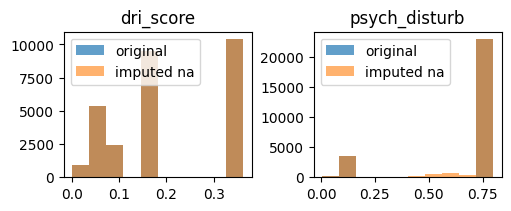

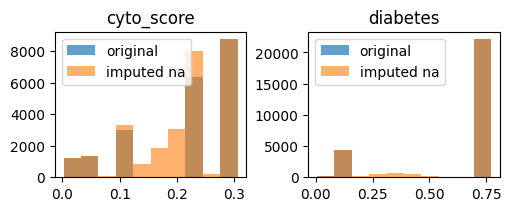

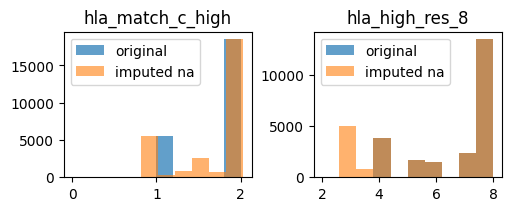

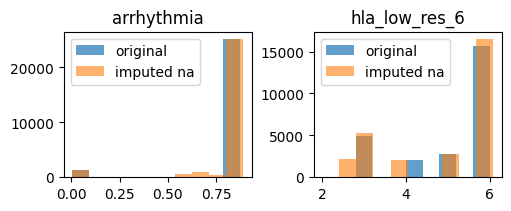

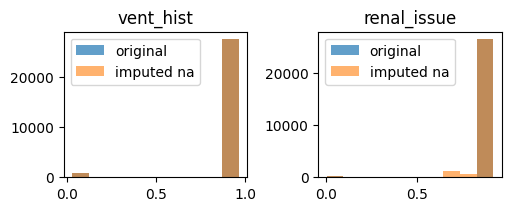

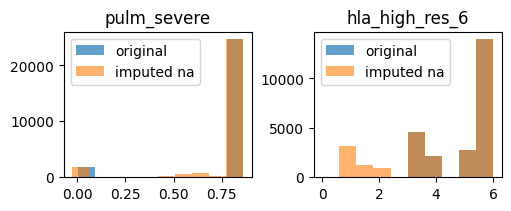

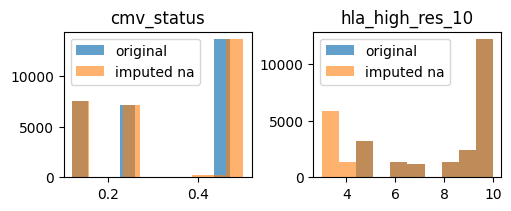

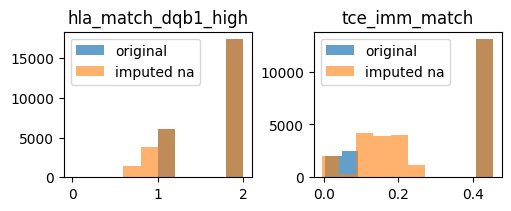

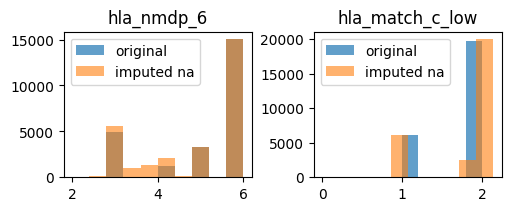

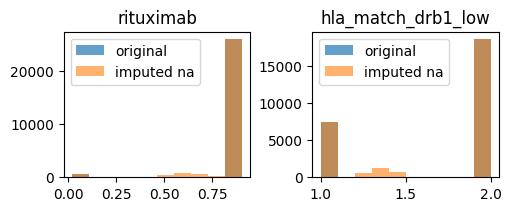

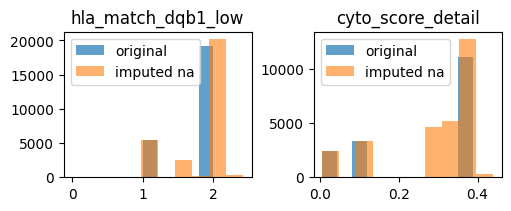

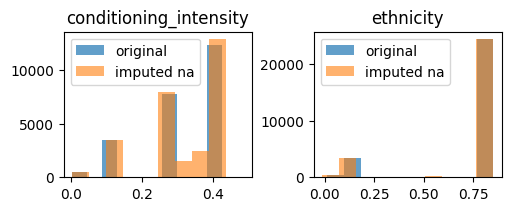

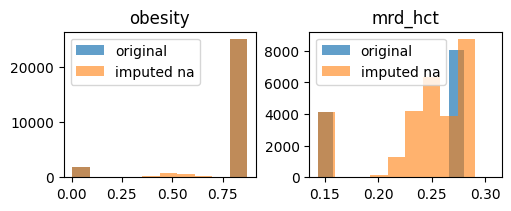

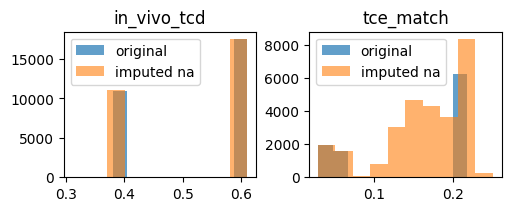

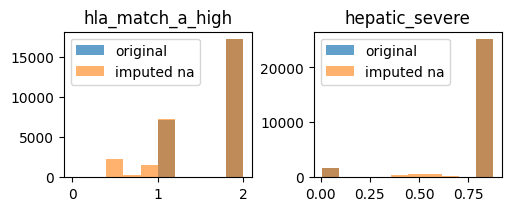

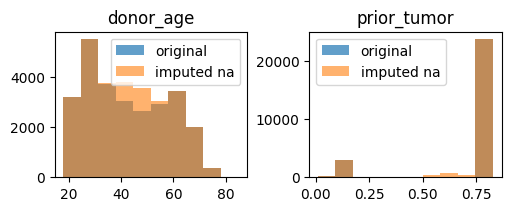

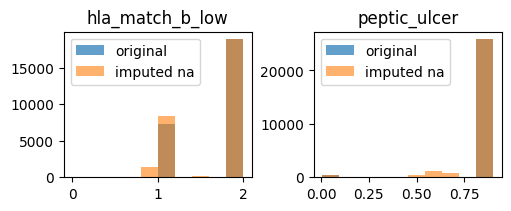

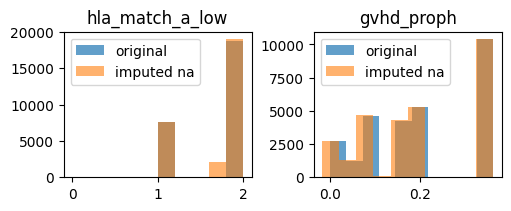

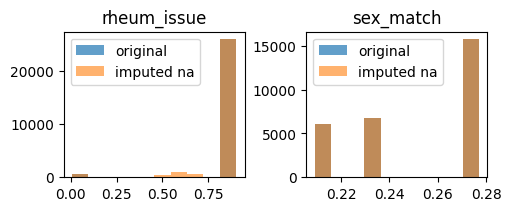

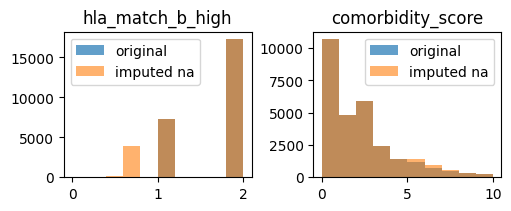

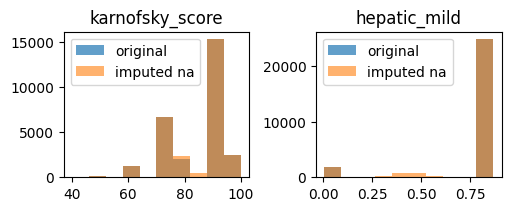

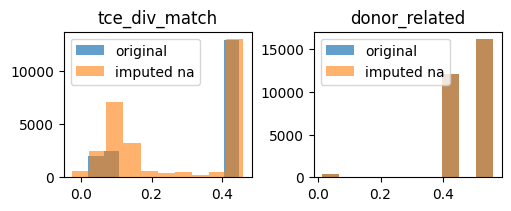

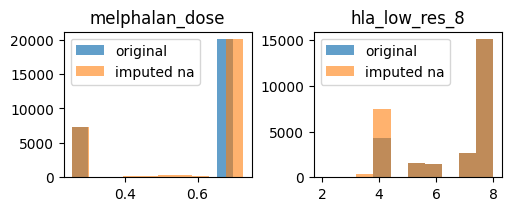

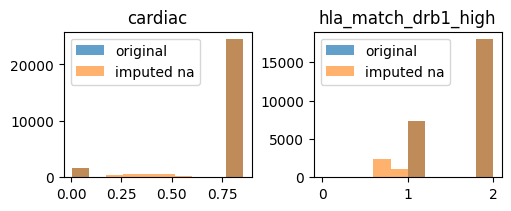

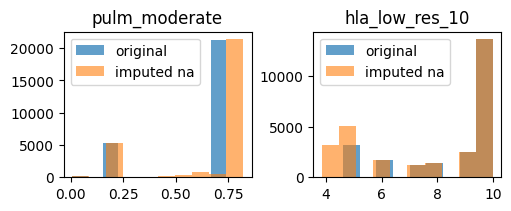

In [7]:
cols_missing_values = [col for col in train.columns if train[col].isna().sum() > 0]

for i in range(0, len(cols_missing_values), 2):
    fig, axes = plt.subplots(1, 2, figsize=(5, 2), constrained_layout=True)
    for j, ax in enumerate(axes):
        if i + j < len(cols_missing_values):
            column_name = cols_missing_values[i + j]
            ax.hist(train_encoded_original[column_name].dropna(), alpha=0.7, label='original')
            ax.hist(train_imputed_lgbm[column_name], alpha=0.6, label='imputed na')
            ax.set_title(column_name)
            ax.legend()

    plt.show()


# Autoencoders

https://www.jair.org/index.php/jair/article/view/12312

https://www.worldscientific.com/doi/abs/10.1142/9789813207813_0021

https://www.sciencedirect.com/science/article/abs/pii/S0925231219310720

"While a vanilla AE learns a compressed representation of the input data, the VAE learns a set of distribution parameters which describe the data, usually the mean and variance of a Gaussian probability function. By sampling from these parameters, the VAE is capable of generating data instances with the same characteristics."

The optimization problem for the VAE:
   $$\phi^* = \arg\min_{\phi} \mathbb{E}_{x \sim p_{\text{pop}}, \, z \sim p_{\phi}(z|x)} \left[ \ln \frac{p_{\phi}(z|x)}{p(z)} - \ln p_{\phi}(x|z) \right]$$

Equivalent reformulation:
   $$\phi^* = \arg\min_{\phi} \mathbb{E}_{(x, z) \sim p_{\text{pop}}} \left[ -\ln \frac{p_{\phi, \text{gen}}(y, z)}{p_{\phi}(z|y)} \right]$$

Further reformulation into KL divergence and reconstruction terms:
   $$\phi^* = \arg\min_{\phi} \mathbb{E}_{x \sim p_{\text{pop}}} \left[ \text{KL}(p_{\phi}(z|x) \parallel p(z)) \right] + \mathbb{E}_{x \sim p_{\phi}(z|x)} \left[ -\ln p_{\phi}(x|z) \right]$$


Assumptions for distributions:
   - Posterior approximation:
     $p_{\phi}(z|x) = \mathcal{N}(\mu_{\phi, z}(x), \Sigma_{\phi, z}(x))$

Approximated via the reparameterization trick.

   - Likelihood model:
     $p_{\phi}(x|z) = \mathcal{N}(\mu_{\phi, x}(z), \sigma^2 I)$

   - Prior:
     $p_{\text{prior}}(z) \sim \mathcal{N}(0, I)$

Relationship between generation and encoding:
   - Decoder:
     $p_{\phi, \text{gen}}(z, x) = p_{\phi}(x|z) \cdot p_{\text{prior}}(z)$
   - Encoder:
     $p_{\phi, \text{enc}}(z, x) = p_{\phi}(z|x) \cdot p_{\text{pop}}(x)$

Implementation based a bit on https://github.com/gevaertlab/BetaVAEImputation/blob/master/autoencodersbetaVAE.py and https://github.com/Harry24k/MIDA-pytorch/blob/master/MIDA.ipynb

In [8]:
theta = 10

class ImputerVAE(nn.Module):
    def __init__(self, input_dim):
        super(ImputerVAE, self).__init__()
        
        # self.latent_dim = latent_dim
        self.input_dim = input_dim

        # maps x to a 50-dim vector
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, self.input_dim + theta),
            nn.ReLU(),
            nn.Linear(self.input_dim + theta, self.input_dim + theta*2),
            nn.ReLU(),
            nn.Linear(self.input_dim + theta*2, self.input_dim + theta*3),
            nn.ReLU()
        )

        # self.mu and self.logvar maps 50-dim vector to
        # the mean vector and the log diag of the covar matrix
        self.mu = nn.Linear(self.input_dim + theta * 3, self.input_dim + theta * 3)
        self.logvar = nn.Linear(self.input_dim + theta * 3, self.input_dim + theta * 3)


        self.decoder = nn.Sequential(
            nn.Linear(self.input_dim + theta*3, self.input_dim + theta*2),
            nn.ReLU(),
            nn.Linear(self.input_dim + theta*2, self.input_dim + theta),
            nn.ReLU(),
            nn.Linear(self.input_dim + theta, self.input_dim)
        )

    def encode(self, x):
        '''
        receives samples x
        returns
            mean vector mu_z(x)
            element-wise log of the diagonal of Sigma_z(x)
        '''
        # implementation goes here
        x = self.encoder(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def sample(self, mu, logvar):
        '''
        takes mu and logvar (the outputs of encode) as input
        reparameterization trick
        returns samples from the corresponding Gaussian distribution
        '''
        epsilon = torch.normal(0., 1., size=mu.size()).to(device)
        stddev = torch.exp(0.5 * logvar)
        z = mu + stddev * epsilon
        return z

    def decode(self, z):
        '''
        takes z latenth variable as input
        returns reconstructed x
        '''
        # implementation goes here
        x_hat = self.decoder(z)
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        x_hat = self.decode(z)
        return mu, logvar, x_hat


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
lr = 0.005
placeholder = 0
epochs = 30
beta = 4

train_encoded_original_no_id = train_encoded_original.drop("ID", axis=1)
train_encoded_original_no_id = torch.from_numpy(train_encoded_original_no_id.values).float()

missing_mask = torch.isnan(train_encoded_original_no_id)

# normalize only the non-missing values
train_mean = train_encoded_original_no_id[~missing_mask].mean(dim=0)
train_std = train_encoded_original_no_id[~missing_mask].std(dim=0)

# recheck this # TODO
# train_encoded_original_no_id[missing_mask] = train_mean 
train_encoded_original_no_id[missing_mask] = placeholder 

train_encoded_original_no_id = (train_encoded_original_no_id - train_mean) / train_std

train_loader = torch.utils.data.DataLoader(
    dataset=train_encoded_original_no_id,
    batch_size=batch_size,
    shuffle=True) 

# vae_model = ImputerVAE(latent_dim=train_encoded_original_no_id.shape[1]).to(device)
vae_model = ImputerVAE(input_dim=train_encoded_original_no_id.shape[1]).to(device)


def vae_loss(x, reconst_x, mu, logvar, loss_kind="variational", beta=beta):
    if loss_kind == "variational":
        # implementation goes here (-lnP(x|z))
        # assume standard deviation or sigma is equal to 1
        recons_loss = torch.sum((x - reconst_x).pow(2))
        # recons_loss = torch.mean((x - reconst_x).pow(2))
        # implementation goes here (KLD)
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recons_loss + beta * kld_loss
    elif loss_kind == "mse":
        return F.mse_loss(x, reconst_x)

def train_vae(vae_model, data=train_loader, epochs=epochs, batch_size=batch_size, lr=lr):
    
    # initialize optimizer
    optimizer = optim.Adam(vae_model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        vae_model.train()
        total_loss = 0
        num_batches = 0

        for idx, batch in enumerate(data):
            batch = batch.to(device)
            mu, logvar, reconst_x = vae_model(batch)
            
            # learn loss
            optimizer.zero_grad()
            loss = vae_loss(batch, reconst_x, mu, logvar, loss_kind="variational")
            loss.backward()
            optimizer.step()
                  
            total_loss += loss.item()
            num_batches += 1
        
        print(f"epoch {epoch + 1}, loss: {total_loss / num_batches:.4f}")

train_vae(vae_model)

epoch 1, loss: 331.6047
epoch 2, loss: 31.8809
epoch 3, loss: 15.5825
epoch 4, loss: 7.2288
epoch 5, loss: 4.5386
epoch 6, loss: 3.8343
epoch 7, loss: 3.6488
epoch 8, loss: 3.6752
epoch 9, loss: 3.8687
epoch 10, loss: 3.9026
epoch 11, loss: 4.4012
epoch 12, loss: 4.1136
epoch 13, loss: 3.8744
epoch 14, loss: 4.4821
epoch 15, loss: 4.2607
epoch 16, loss: 4.1725
epoch 17, loss: 3.8937
epoch 18, loss: 3.8446
epoch 19, loss: 4.6837
epoch 20, loss: 3.4986
epoch 21, loss: 3.5983
epoch 22, loss: 4.1490
epoch 23, loss: 3.5070
epoch 24, loss: 3.6694
epoch 25, loss: 4.1529
epoch 26, loss: 3.2826
epoch 27, loss: 3.8070
epoch 28, loss: 3.4604
epoch 29, loss: 3.6265
epoch 30, loss: 3.3551


In [9]:
vae_model.eval()
missing_mask = missing_mask.to(device)
train_encoded_original_no_id = train_encoded_original_no_id.to(device)

with torch.no_grad():
    _, _, imputed_data = vae_model(train_encoded_original_no_id)
    imputed_data = imputed_data.cpu().detach().numpy()

train_imputed_vae = pd.DataFrame(
    train_encoded_original_no_id.cpu().numpy(), 
    columns=train_encoded_original.drop("ID", axis=1).columns)

for i in range(imputed_data.shape[1]):
    train_imputed_vae.iloc[missing_mask.cpu().numpy()[:, i], i] = imputed_data[:, i][missing_mask.cpu().numpy()[:, i]]

train_imputed_vae = train_imputed_vae * train_std.numpy() + train_mean.numpy()

In [10]:
train_imputed_vae.tail()

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
28795,0.016701,1.088551,0.104549,0.770863,2.0,8.0,0.654896,0.875103,6.0,0.713402,...,0.020592,1.267799,0.699131,8.0,0.553474,2.0,0.740902,10.0,0.0,18.632999
28796,0.163231,0.798786,0.305626,0.150661,1.0,4.0,0.654896,0.875103,5.0,0.713402,...,0.085346,0.562778,0.699131,6.0,0.052742,1.0,0.182259,8.0,1.0,4.892002
28797,0.069550,1.002636,0.305626,1.787567,2.0,8.0,0.654896,1.411343,6.0,0.713402,...,0.085346,0.419724,0.699131,8.0,0.490543,2.0,0.740902,10.0,0.0,23.157000
28798,0.084270,0.798786,0.305626,0.770863,1.0,4.0,0.654896,0.875103,3.0,0.713402,...,0.449165,0.562778,0.252083,4.0,0.853886,1.0,0.740902,5.0,0.0,52.351002
28799,0.165939,0.798786,1.052292,0.770863,2.0,8.0,0.654896,0.875103,6.0,0.286598,...,0.449165,0.562778,0.252083,8.0,0.853886,2.0,0.182259,10.0,0.0,25.158001


In [11]:
train_encoded_original.drop("ID", axis=1).tail()

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
28795,0.016701,NaN,0.104549,0.770868,2.0,8.0,0.654896,0.875104,6.0,0.713403,...,0.020590,NaN,0.699132,8.0,NaN,2.0,0.740903,10.0,0.0,18.633
28796,0.163229,0.798785,0.305625,0.150660,1.0,4.0,0.654896,0.875104,5.0,0.713403,...,0.085347,0.562778,0.699132,6.0,0.052743,1.0,0.182257,8.0,1.0,4.892
28797,0.069549,NaN,0.305625,NaN,2.0,8.0,0.654896,NaN,6.0,0.713403,...,0.085347,0.419722,0.699132,8.0,NaN,2.0,0.740903,10.0,0.0,23.157
28798,0.084271,0.798785,0.305625,0.770868,1.0,4.0,0.654896,0.875104,3.0,0.713403,...,0.449167,0.562778,0.252083,4.0,0.853889,1.0,0.740903,5.0,0.0,52.351
28799,0.165937,0.798785,NaN,0.770868,2.0,8.0,0.654896,0.875104,6.0,0.286597,...,0.449167,0.562778,0.252083,8.0,0.853889,2.0,0.182257,10.0,0.0,25.158


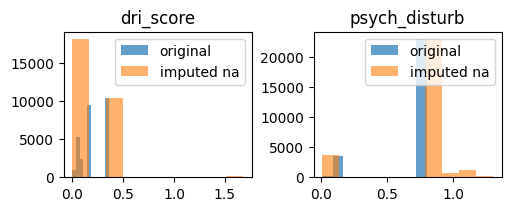

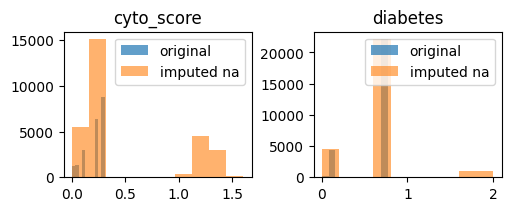

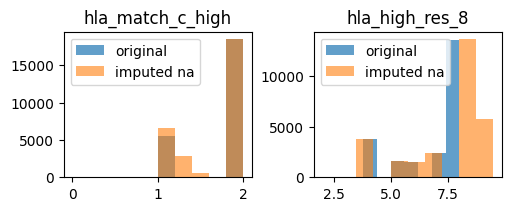

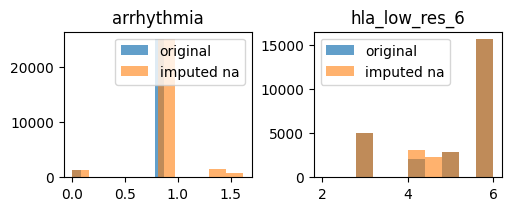

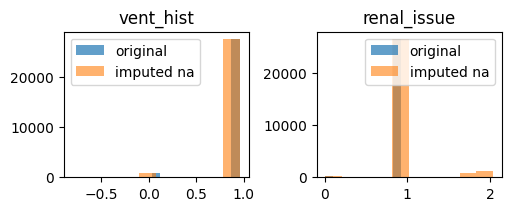

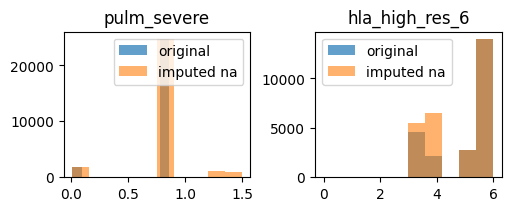

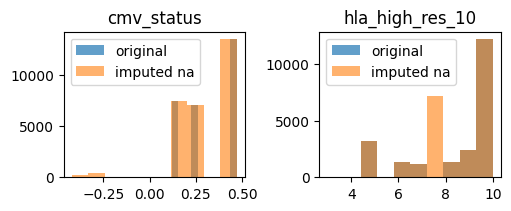

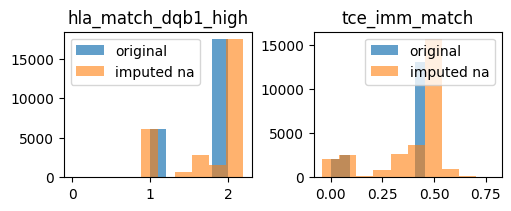

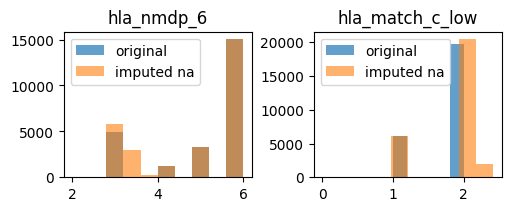

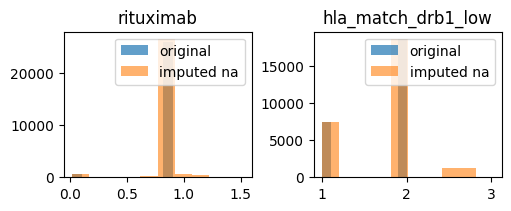

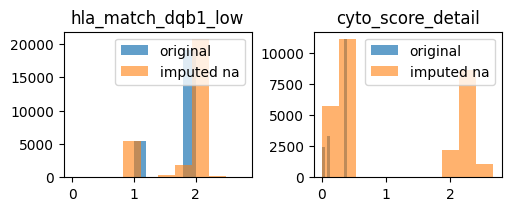

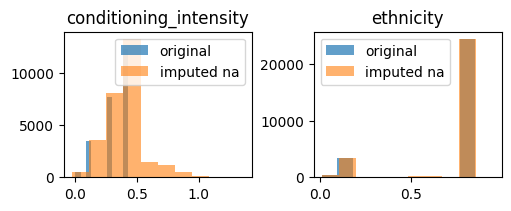

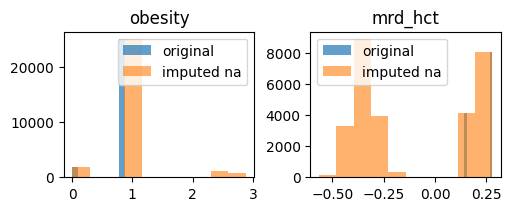

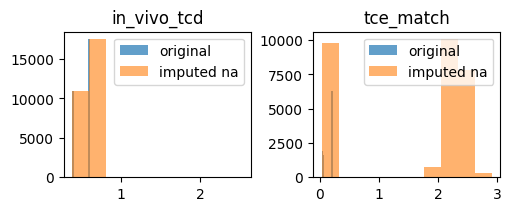

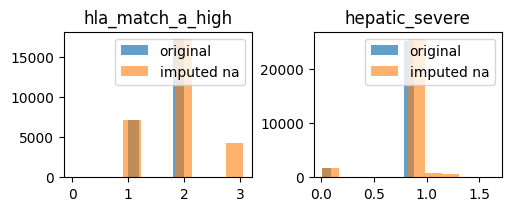

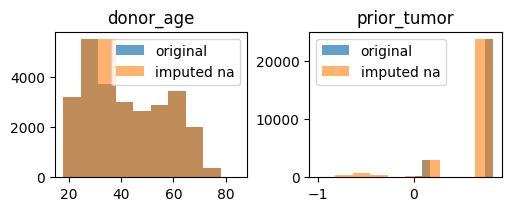

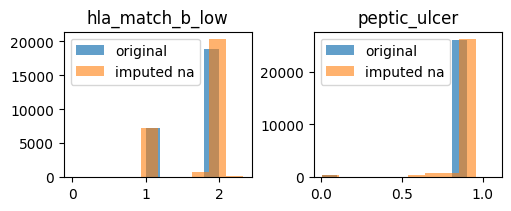

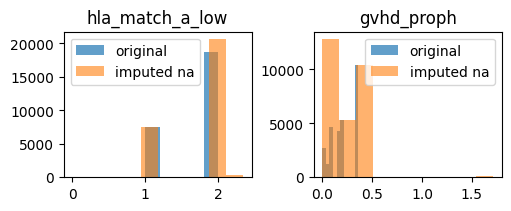

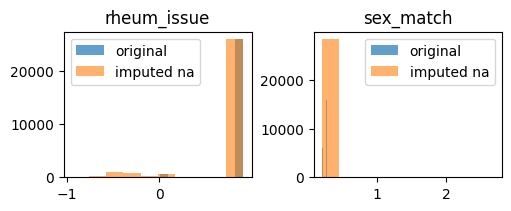

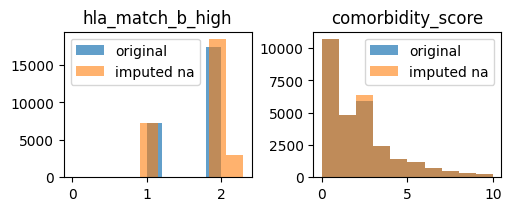

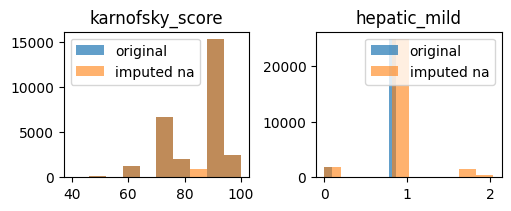

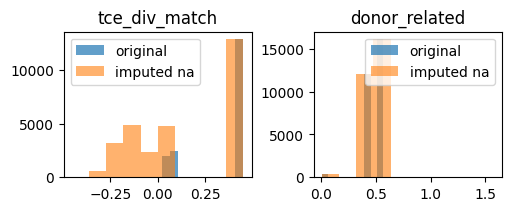

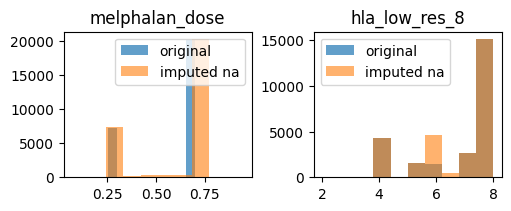

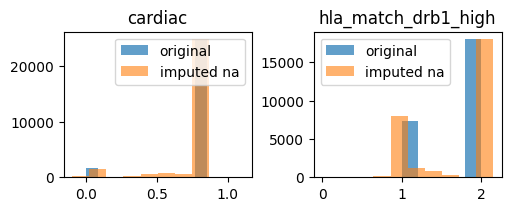

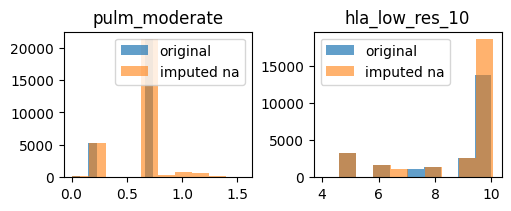

In [12]:
cols_missing_values = [col for col in train.columns if train[col].isna().sum() > 0]

for i in range(0, len(cols_missing_values), 2):
    fig, axes = plt.subplots(1, 2, figsize=(5, 2), constrained_layout=True)
    for j, ax in enumerate(axes):
        if i + j < len(cols_missing_values):
            column_name = cols_missing_values[i + j]
            ax.hist(train_encoded_original[column_name].dropna(), alpha=0.7, label='original')
            ax.hist(train_imputed_vae[column_name], alpha=0.6, label='imputed na')
            ax.set_title(column_name)
            ax.legend()

    plt.show()


# GAIN

Theory: https://proceedings.mlr.press/v80/yoon18a/yoon18a.pdf

Rewrite the tensorflow version of https://github.com/jsyoon0823/GAIN/blob/master/gain.py to pytorch

Reference: Jinsung Yoon, James Jordon, and Mihaela van der Schaar, "GAIN: Missing Data Imputation using Generative Adversarial Nets", In International Conference on Machine Learning (ICML), 2018.

Adapted from the original implementation in tensorflow: https://github.com/jsyoon0823/GAIN

# Compare